## SARS-CoV-2 Genome Mutator

In [74]:
import io
import os
import sys
import pandas as pd
import numpy as np

from webapp import *

from Levenshtein import distance, ratio, hamming
import ipywidgets as widgets
from IPython.display import Javascript, display

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

In [75]:
MODEL_PATH = "data/ncbi_02/model_gru_bi_256"
encoder_model, decoder_model = load_model(model_path=MODEL_PATH)

Loaded model from data/ncbi_02/model_gru_bi_256.


In [76]:
def run_next_cell(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.get_selected_index()+2)'))

In [77]:
file_upload = widgets.FileUpload(accept='.txt', multiple=False, )
display(file_upload)

def on_upload(change):
    run_next_cell(None)

file_upload.observe(on_upload, names='_counter')

FileUpload(value={}, accept='.txt', description='Upload')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [83]:
file = list(file_upload.value.values())[0]
data = pd.read_csv(io.BytesIO(file['content']), names=['seq'])
data['seq_len'] = data.seq.str.len()
run_next_cell(None)
data

<IPython.core.display.Javascript object>

,seq,seq_len
0,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3822
1,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3822
2,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3822
3,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3822
4,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3822


In [84]:
btn_mutate = widgets.Button(description='Mutate', icon='check')
gen_slider = widgets.IntSlider(value=1, min=1, max=10, step=1, description='Generations')

layout = widgets.HBox([
    gen_slider,
    btn_mutate
])
display(layout)

def on_mutate(change):
    run_next_cell(None)

btn_mutate.on_click(on_mutate)

<IPython.core.display.Javascript object>

In [85]:
gen_label = widgets.Label(value='0/0')
gen_progress = widgets.IntProgress(min=1, max=SEQ_LEN)

layout = widgets.HBox([ 
    gen_progress, 
    gen_label 
])
display(layout)

if 'mut' in data.columns:
    seq_vector = encode_seq(data.mut)
else:
    seq_vector = encode_seq(data.seq)

for i in range(gen_slider.value):
    
    gen_label.value = f'{i + 1}/{gen_slider.value}'
    
    seq_vector = decode_sequence_batch(input_seqs=seq_vector,
                                       encoder_model=encoder_model,
                                       decoder_model=decoder_model,
                                       progress=gen_progress)
    
run_next_cell(None)

<IPython.core.display.Javascript object>

In [86]:
data['mut'] = decode_seq(seq_vector)
data['mut'] = ('A' + data.mut).str[:-1]
data['mut_len'] = data.mut.str.len()

data['lev_distance'] = [ distance(x,y) for x,y in zip(data.seq, data.mut) ]
data['lev_ratio'] = [ ratio(x,y) for x,y in zip(data.seq, data.mut) ]
data['hamming'] = [ hamming(x,y) for x,y in zip(data.seq, data.mut) ]

run_next_cell(None)

data

<IPython.core.display.Javascript object>

,seq,seq_len,mut,mut_len,lev_distance,lev_ratio,hamming
0,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3822,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3822,12,0.996860,12
1,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3822,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3822,10,0.997384,10
2,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3822,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3822,7,0.998168,7
3,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3822,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3822,6,0.998430,6
4,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3822,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3822,9,0.997645,9


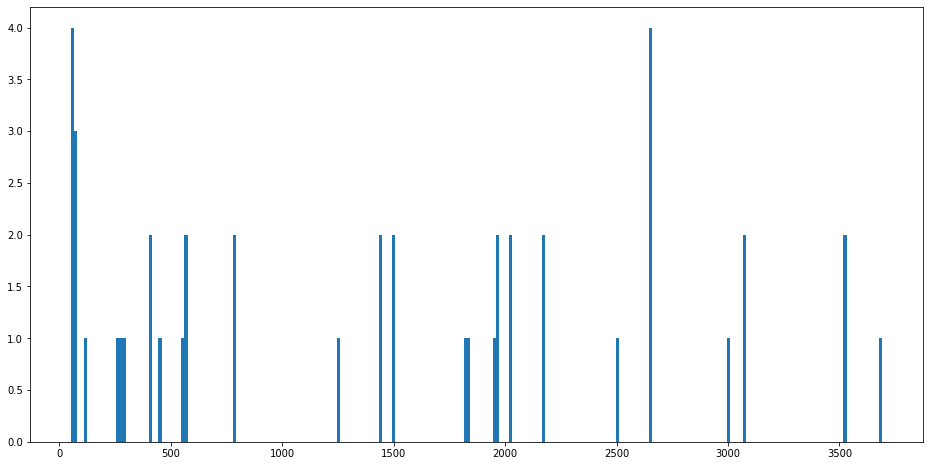

In [87]:
freq = None
for i in range(len(data)):
    d = np.where(~(np.array(list(data.seq[i])) == np.array(list(data.mut[i]))))[0]
    freq = d if freq is None else np.append(freq, d)

plt.hist(freq, bins=250)
plt.show()